# Example notebook: Simulating SKA-Low noise

**Authors**: Sambit K. Giri, Adelie Gorce, Ian Hothi <br>
**Date created**: 2 June 2025

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from astropy.cosmology import Planck18 as cos
from astropy import units, constants
#For Power Spectrum Calculations 
import tools21cm as t2c

In [2]:
seed = 123456 # Choose your favorite number
np.random.seed(seed)

## Load metadata and simulation

In [3]:
# Folder containing the simulations
ddir = './SKA_chapter_simulations/'
# File with fiducial lightcone
file = ddir+'Lightcone_FID_400_Samples.h5'

In [4]:
# Read h5py file to obtain metadata
with h5py.File(file, 'r') as f:
    frequencies = f['frequencies'][...]  # frequencies along the lightcone
    redshifts = f['redshifts'][...]  # redshifts along the lightcone
    box_length = float(f['box_length'][0])  # Mpc
    ngrid = int(f['ngrid'][0])  # number of pixels along the sky patch
    nrand = int(f['nrealisations'][0])  # number of realisations for a given parameter set
nfreq = frequencies.size
print(f'Lightcone runs from z={redshifts.min():.2f} to z = {redshifts.max():.2f}.')

Lightcone runs from z=8.82 to z = 9.33.


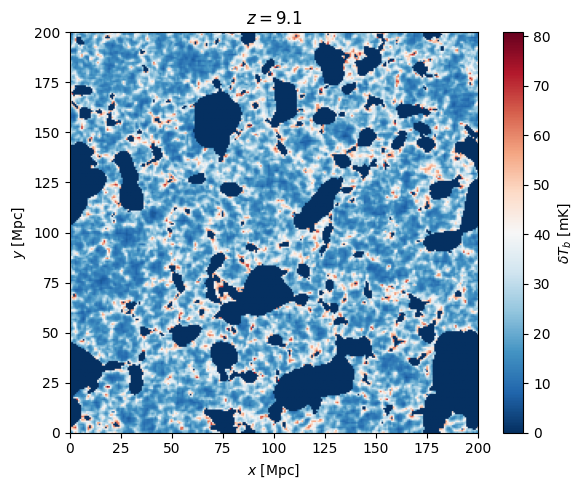

In [5]:
# Read h5py file for iz-th redshift and i-th realisation
iz = np.random.randint(nfreq)
i = np.random.randint(nrand)

with h5py.File(file, 'r') as f:
    coeval_slice = f['brightness_lightcone'][i, iz, :, :]  # Reads only (nz, n, n), not entire data

iz = 50

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
im = ax.imshow(
    coeval_slice,
    extent=(0, box_length, 0, box_length),
    origin='lower', cmap='RdBu_r', aspect='auto'
    )
ax.set_xlabel(r'$x$ [Mpc]')
ax.set_ylabel(r'$y$ [Mpc]')
plt.colorbar(im, label=r'$\delta T_b$ [mK]')
ax.set_title(rf'$z={redshifts[iz]:.1f}$')
fig.tight_layout()

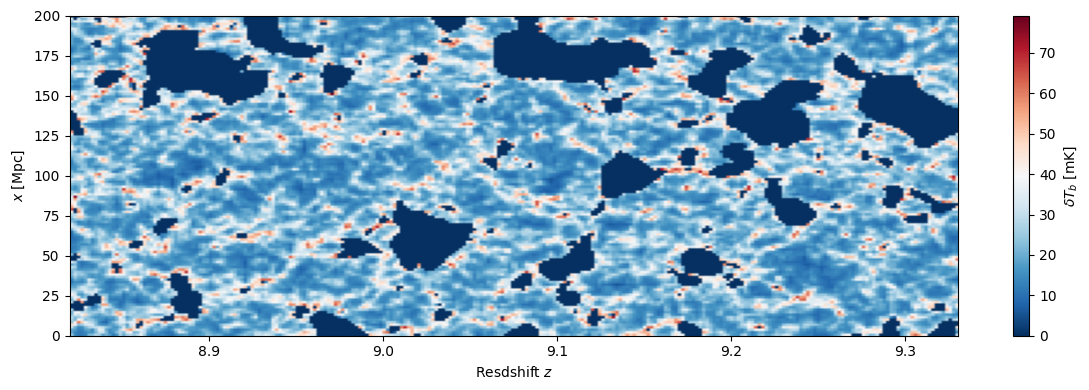

In [6]:
# Read h5py file for slice of lightcone iz-th redshift and i-th realisation
ix = np.random.randint(ngrid)

with h5py.File(file, 'r') as f:
    lc = f['brightness_lightcone'][i, :, ix, :]  # Reads only (nz, n, n), not entire data

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
im = ax.imshow(
    lc,
    extent=(redshifts.min(), redshifts.max(), 0, box_length),
    origin='lower', cmap='RdBu_r', aspect='auto'
    )
ax.set_xlabel(r'Resdshift $z$')
ax.set_ylabel(r'$x$ [Mpc]')
plt.colorbar(im, label=r'$\delta T_b$ [mK]')
fig.tight_layout()

## Apply SKA AA* observational effects

This is the procedure also followed in `compute_statistic`.

In [7]:
# read lightcone
with h5py.File(file, 'r') as f:
    lc = f['brightness_lightcone'][np.random.randint(nrand), ...]
# move los axis to match t2c
lc = np.moveaxis(lc, 0, 2)

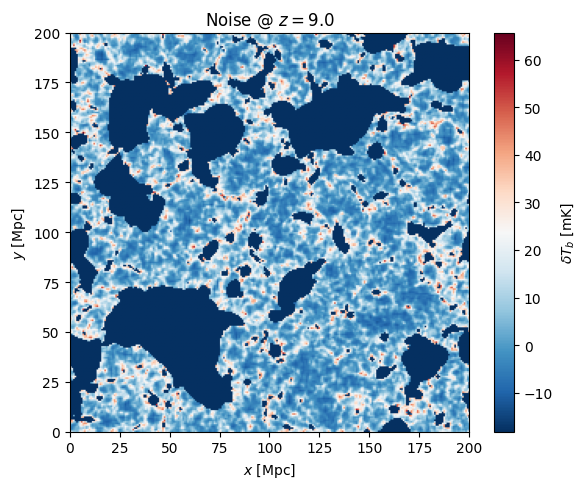

In [8]:
iz = np.abs(redshifts-9).argmin()

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
im = ax.imshow(
    t2c.subtract_mean_signal(lc, los_axis=2)[..., iz],
    extent=(0, box_length, 0, box_length),
    origin='lower', cmap='RdBu_r', aspect='auto',
    # vmin=-np.max(np.abs(lc[..., iz])), vmax=np.max(np.abs(lc[..., iz])),
    )
ax.set_xlabel(r'$x$ [Mpc]')
ax.set_ylabel(r'$y$ [Mpc]')
plt.colorbar(im, label=r'$\delta T_b$ [mK]')
ax.set_title(rf'Noise @ $z={redshifts[iz]:.1f}$')
fig.tight_layout()

In [9]:
# SKA obs parameters
obs_time = 1000.  # hours
int_time = 10.  # seconds
total_int_time = 6.  # hours per day
declination = -30.0  # declination of the field in degrees
bmax = 2. * units.km  # km

In [10]:
subarray_type_list = ["AAstar", "AA4"]
noise_lc = {}

for subarray_type in subarray_type_list: 
    save_uvmap = ddir+f'uvmap_{subarray_type}_{total_int_time}h_perday.h5'
    print(f'The uv weight maps will be saved as {save_uvmap}') 
    
    # generate noise lightcone
    noise_lc[subarray_type] = t2c.noise_lightcone(
        ncells=ngrid,
        zs=redshifts,
        obs_time=obs_time,
        total_int_time=total_int_time,
        int_time=int_time,
        declination=declination,
        subarray_type=subarray_type,
        boxsize=box_length,
        verbose=False,
        save_uvmap=save_uvmap,  # save uv coverage to re-use for each realisation
        n_jobs=1, #4,
        checkpoint=16,
    )  # third axis is line of sight
    print(subarray_type, np.std(lc), np.std(noise_lc[subarray_type]))

The uv weight maps will be saved as ./SKA_chapter_simulations/uvmap_AAstar_6.0h_perday.h5
Creating the uv maps.
1/128 | z=9.330...time elapsed = 0.00 mins
2/128 | z=9.326...time elapsed = 0.00 mins
3/128 | z=9.322...time elapsed = 0.00 mins
4/128 | z=9.318...time elapsed = 0.00 mins
5/128 | z=9.313...time elapsed = 0.00 mins
6/128 | z=9.309...time elapsed = 0.00 mins
7/128 | z=9.305...time elapsed = 0.00 mins
8/128 | z=9.301...time elapsed = 0.00 mins
9/128 | z=9.297...time elapsed = 0.00 mins
10/128 | z=9.292...time elapsed = 0.00 mins
11/128 | z=9.288...time elapsed = 0.00 mins
12/128 | z=9.284...time elapsed = 0.00 mins
13/128 | z=9.280...time elapsed = 0.00 mins
14/128 | z=9.276...time elapsed = 0.00 mins
15/128 | z=9.271...time elapsed = 0.00 mins
16/128 | z=9.267...time elapsed = 0.00 mins
17/128 | z=9.263...time elapsed = 0.00 mins
18/128 | z=9.259...time elapsed = 0.00 mins
19/128 | z=9.255...time elapsed = 0.00 mins
20/128 | z=9.251...time elapsed = 0.00 mins
21/128 | z=9.246.

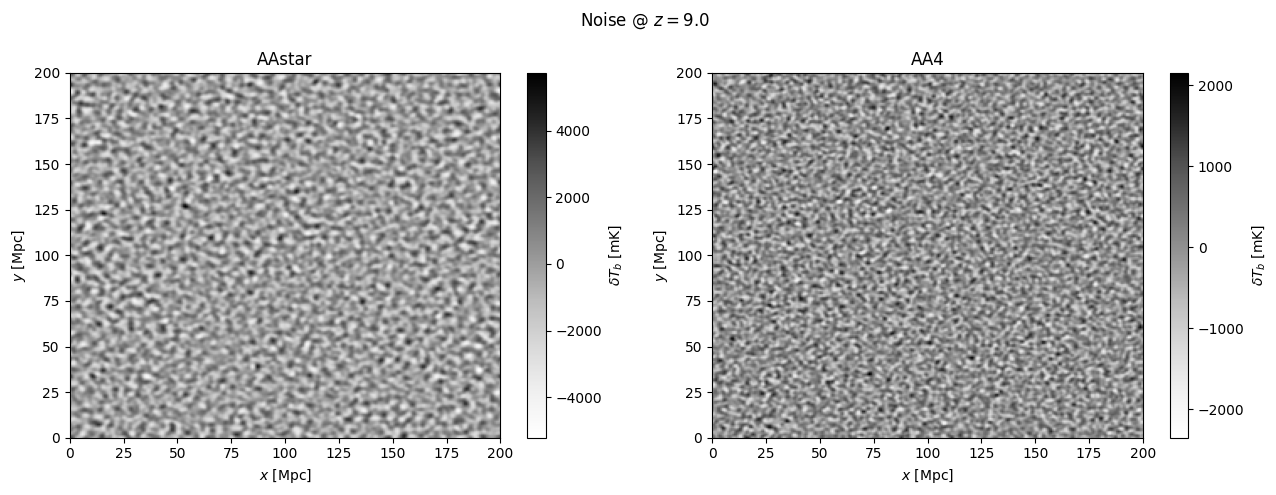

In [11]:
iz = np.abs(redshifts-9).argmin()

fig, axs = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle(rf'Noise @ $z={redshifts[iz]:.1f}$')
for i,subarray_type in enumerate(subarray_type_list): 
    ax = axs[i]
    im = ax.imshow(
        noise_lc[subarray_type][..., iz],
        extent=(0, box_length, 0, box_length),
        origin='lower', cmap='Greys', aspect='auto'
        )
    ax.set_xlabel(r'$x$ [Mpc]')
    ax.set_ylabel(r'$y$ [Mpc]')
    fig.colorbar(im, ax=ax, label=r'$\delta T_b$ [mK]')
    ax.set_title(rf'{subarray_type}')
fig.tight_layout()

In [12]:
noisy_lc = {ke: noise_lc[ke] + t2c.subtract_mean_signal(lc, los_axis=2)
            for ke in noise_lc.keys()}
dt_obs = {}
for i,subarray_type in enumerate(subarray_type_list): 
    dt_obs[subarray_type], zs_obs = t2c.smooth_lightcone(
        noisy_lc[subarray_type], 
        redshifts, 
        box_size_mpc=box_length,
        max_baseline=2.0, #km
    )

100%|██████████| 128/128 [00:00<00:00, 213.10it/s]


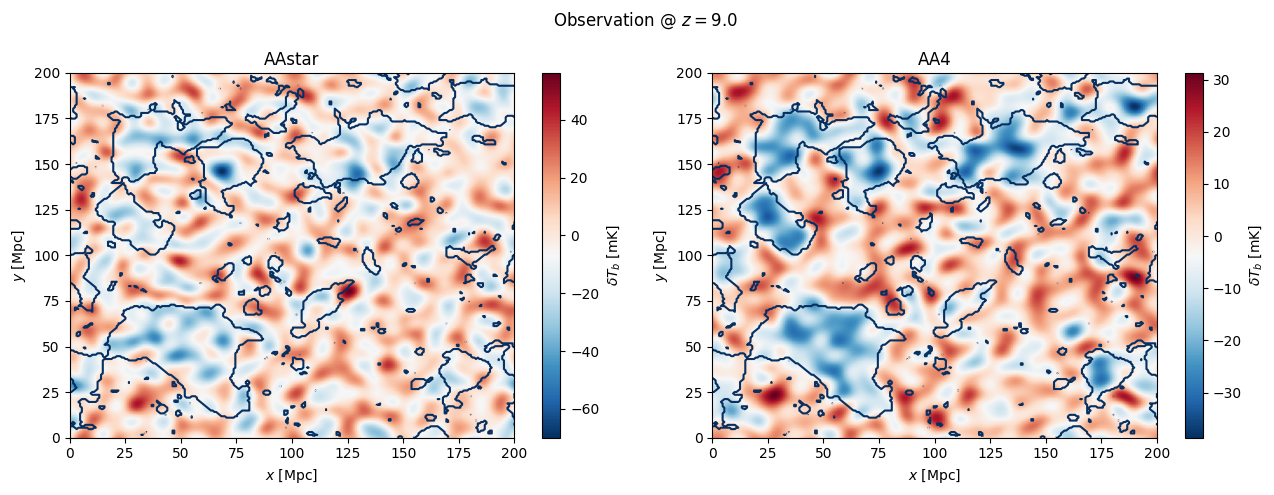

In [13]:
iz = np.abs(redshifts-9).argmin()

fig, axs = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle(rf'Observation @ $z={redshifts[iz]:.1f}$')
for i,subarray_type in enumerate(subarray_type_list): 
    ax = axs[i]
    im = ax.imshow(
        dt_obs[subarray_type][..., iz],
        extent=(0, box_length, 0, box_length),
        origin='lower', cmap='RdBu_r', aspect='auto',
        # vmin=-np.max(np.abs(lc[..., iz])), vmax=np.max(np.abs(lc[..., iz])),
        )
    xi = np.linspace(0, box_length, ngrid)
    ax.contour(xi, xi, lc[...,iz], levels=[1e-4], cmap="RdBu_r")
    ax.set_xlabel(r'$x$ [Mpc]')
    ax.set_ylabel(r'$y$ [Mpc]')
    fig.colorbar(im, ax=ax, label=r'$\delta T_b$ [mK]')
    ax.set_title(rf'{subarray_type}')
fig.tight_layout()

## Power spectrum

In [14]:
# Power spectra
nbins = 15
k_nyquist = np.pi/box_length*ngrid
box_length_los = np.abs(cos.comoving_distance(redshifts.max())-cos.comoving_distance(redshifts.min())).value
box_dims = [box_length, box_length, box_length_los] # This is important as the third or los axis has a different physical length.
# Fiducial 
ps, ks = t2c.power_spectrum_1d(lc, kbins=nbins, box_dims=box_dims)
pn = {ke: t2c.power_spectrum_1d(noise_lc[ke], kbins=nbins, box_dims=box_dims)[0][ks<k_nyquist/2]
      for ke in noise_lc.keys()}
ps, ks = ps[ks<k_nyquist/2], ks[ks<k_nyquist/2]

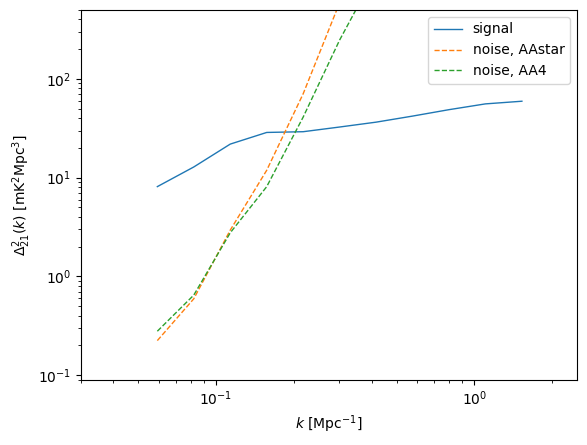

In [15]:
fig, ax = plt.subplots()
ax.loglog(ks, ps*ks**3/2/np.pi**2, lw=1., ls='-', label='signal')
for ke in pn.keys():
    ax.loglog(ks, pn[ke]*ks**3/2/np.pi**2, lw=1., ls='--', label=f'noise, {ke}')
ax.set_ylabel(r'$\Delta^2_{21}(k)$ [mK$^2$Mpc$^3$]')
ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
ax.axis([3e-2,2.5,9e-2,5e2])
ax.legend()